In [5]:
pip install scikit-learn xgboost joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import pandas as pd
import numpy as np


In [7]:
# Load the dataset you created
df = pd.read_csv("descriptor.csv")
df = df.copy()
df = df[df['Kd'].notnull()]  # Remove NaN
df = df[np.isfinite(df['Kd'])]  # Remove inf/-inf

X = df.drop("Kd", axis=1)
y = df["Kd"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [8]:
df.describe()

,MolWt,LogP,RotatableBonds,HDonors,HAcceptors,Prot_MW,Aromaticity,Instability,Hydropathy,Kd
count,54980.000000,54980.000000,54980.000000,54980.000000,54980.000000,54980.000000,54980.000000,54980.000000,54980.000000,54980.000000
mean,492.785824,3.365187,7.307475,2.774882,6.904038,75946.460221,0.084149,46.460879,-0.357576,6.053402
std,296.939830,3.023129,8.518526,3.992615,5.685136,54435.772325,0.020080,10.536910,0.296621,1.572272
min,46.073000,-48.012300,0.000000,0.000000,0.000000,2448.512800,0.000000,0.307930,-1.610233,0.020000
25%,369.434250,2.544500,4.000000,1.000000,5.000000,44460.111700,0.070175,40.829129,-0.522418,5.000000
50%,450.345000,3.633300,6.000000,2.000000,6.000000,59473.333200,0.082854,46.361345,-0.371148,5.443697
75%,527.669000,5.024100,8.000000,3.000000,8.000000,92849.581300,0.097222,52.685901,-0.239002,7.045757
max,10112.436000,16.784400,178.000000,98.000000,276.000000,794048.925800,0.186441,90.878018,1.171429,15.221849


In [9]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

In [10]:
stacking_model.fit(X_train, y_train)


StackingRegressor(cv=5,
                  estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_p...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('gbr',
                               GradientBoostingRegressor(random_state=42))],
                  final_estimator=LinearRegression())

In [11]:
y_pred = stacking_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Stacked Ensemble MSE:", mse)

Stacked Ensemble MSE: 1.4491787104799323


In [12]:
dump(stacking_model, 'stacked_model.joblib')

['stacked_model.joblib']

In [13]:
test = pd.read_csv("descriptor_test.csv")
x_test = test.drop("Kd", axis=1)
y_test = test["Kd"]

In [14]:
loaded_model = load('stacked_model.joblib')
y_pred = loaded_model.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 1.4496
Mean Absolute Error: 0.8980
Root Mean Squared Error: 1.2040


C:\Users\NongNam\AppData\Local\Temp\ipykernel_10492\897430231.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="True Kd", shade=True)
C:\Users\NongNam\AppData\Local\Temp\ipykernel_10492\897430231.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Predicted Kd", shade=True)


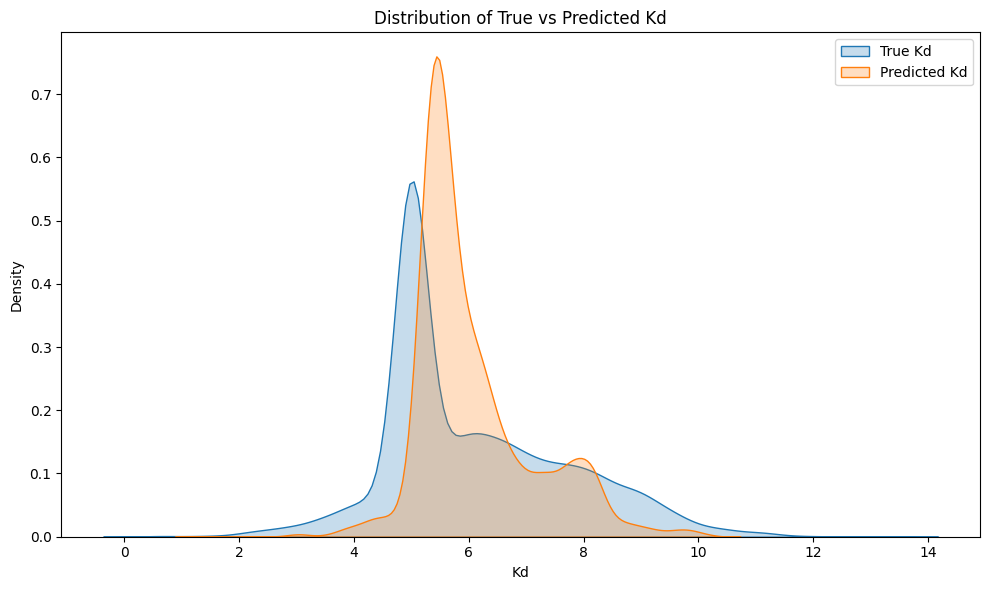

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot real vs predicted distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label="True Kd", shade=True)
sns.kdeplot(y_pred, label="Predicted Kd", shade=True)
plt.title("Distribution of True vs Predicted Kd")
plt.xlabel("Kd")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()